In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/predict-the-success-of-bank-telemarketing/sample_submission.csv
/kaggle/input/predict-the-success-of-bank-telemarketing/train.csv
/kaggle/input/predict-the-success-of-bank-telemarketing/test.csv


# Content
* [Library Imports](#L)
* [Data Extraction](#D)
* [Dummy Classifier](#D1)
* [Exploratory Data Analysis (EDA)](#eda)
  * [Comparison with Target](#Com)
  * [Analysis](#ana)
    * [Target Distribution](#tar)
* [Imputation](#imp)
* [Preprocessing and feature engineering](#pre)
* [Model Training](#mod)
* [Hyper Parameter Tuning](#hyp)
* [Model Evaluation](#eval)
* [Submission](#sub)

<a id='L'></a>
## Library Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler,OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, RFE
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

<a id='D'></a>
## Data Extraction

In [3]:
train = pd.read_csv("/kaggle/input/predict-the-success-of-bank-telemarketing/train.csv")
test = pd.read_csv("/kaggle/input/predict-the-success-of-bank-telemarketing/test.csv")

<a id='D1'></a>
## Dummy Classifier

In [4]:
#df=pd.read_csv('/kaggle/input/predict-the-success-of-bank-telemarketing/train.csv')
#X=df.drop('target',axis=1)
#y=df['target']
#from sklearn.dummy import DummyClassifier
#model=DummyClassifier(strategy='most_frequent').fit(X,y)
#X_test=pd.read_csv('/kaggle/input/predict-the-success-of-bank-telemarketing/test.csv')
#y_pred=model.predict(X_test)
#submission=pd.DataFrame({'id':range(0,10000),
#                          'target':y_pred})
#submission.to_csv('submission.csv',index=False)

<a id='eda'></a>
## Exploratory Data Analysis (EDA)

In [5]:
train.head()

,last contact date,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,target
0,2009-04-17,26,blue-collar,married,secondary,no,647,yes,no,cellular,357,2,331,1,other,no
1,2009-10-11,52,technician,married,secondary,no,553,yes,no,telephone,160,1,-1,0,NaN,no
2,2010-11-20,44,blue-collar,married,secondary,no,1397,no,no,cellular,326,1,-1,0,NaN,no
3,2009-09-01,33,admin.,married,secondary,no,394,yes,no,telephone,104,3,-1,0,NaN,no
4,2008-01-29,31,entrepreneur,single,tertiary,no,137,no,no,cellular,445,2,-1,0,NaN,no


In [6]:
test.head()

,last contact date,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome
0,2009-11-21,36,management,single,tertiary,no,7,no,no,NaN,20,1,-1,0,NaN
1,2010-02-04,30,unemployed,married,tertiary,no,1067,no,no,cellular,78,2,-1,0,NaN
2,2010-07-28,32,blue-collar,single,secondary,no,82,yes,no,cellular,86,4,-1,0,NaN
3,2010-06-09,38,admin.,married,primary,no,1487,no,no,NaN,332,2,-1,0,NaN
4,2008-03-02,59,management,married,tertiary,no,315,no,no,cellular,591,1,176,2,failure


*checked Test and Train sample Upperpart*

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39211 entries, 0 to 39210
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   last contact date  39211 non-null  object
 1   age                39211 non-null  int64 
 2   job                38982 non-null  object
 3   marital            39211 non-null  object
 4   education          37744 non-null  object
 5   default            39211 non-null  object
 6   balance            39211 non-null  int64 
 7   housing            39211 non-null  object
 8   loan               39211 non-null  object
 9   contact            28875 non-null  object
 10  duration           39211 non-null  int64 
 11  campaign           39211 non-null  int64 
 12  pdays              39211 non-null  int64 
 13  previous           39211 non-null  int64 
 14  poutcome           9760 non-null   object
 15  target             39211 non-null  object
dtypes: int64(6), object(10)
memory usage: 4.

*Got Train data Information*

**Discriptive statitics of numarical columns in the dataset**

In [8]:
train.describe()

,age,balance,duration,campaign,pdays,previous
count,39211.000000,39211.000000,39211.000000,39211.000000,39211.000000,39211.000000
mean,42.120247,5441.781719,439.062789,5.108770,72.256051,11.826171
std,12.709352,16365.292065,769.096291,9.890153,160.942593,44.140259
min,18.000000,-8019.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,98.000000,109.000000,1.000000,-1.000000,0.000000
50%,40.000000,549.000000,197.000000,2.000000,-1.000000,0.000000
75%,50.000000,2030.000000,380.000000,4.000000,-1.000000,0.000000
max,95.000000,102127.000000,4918.000000,63.000000,871.000000,275.000000


**Check for null values**

In [9]:
train.isna().sum()

last contact date        0
age                      0
job                    229
marital                  0
education             1467
default                  0
balance                  0
housing                  0
loan                     0
contact              10336
duration                 0
campaign                 0
pdays                    0
previous                 0
poutcome             29451
target                   0
dtype: int64

obtained null value counts on each column

**Obtain value counts in each column**

In [10]:
for column in train.columns:
    print(train[column].value_counts())

last contact date
2009-05-15    313
2008-05-15    301
2009-05-14    292
2010-05-15    292
2009-05-13    279
             ... 
2009-08-09      1
2008-08-30      1
2009-10-31      1
2009-07-26      1
2010-04-12      1
Name: count, Length: 1013, dtype: int64
age
32    1688
31    1629
33    1599
35    1571
34    1566
      ... 
18      44
92      41
87      40
85      39
95       2
Name: count, Length: 78, dtype: int64
job
blue-collar      7776
management       7462
technician       6078
admin.           4116
services         3325
self-employed    1862
retired          1824
entrepreneur     1805
unemployed       1685
housemaid        1656
student          1393
Name: count, dtype: int64
marital
married     22691
single      11250
divorced     5270
Name: count, dtype: int64
education
secondary    19584
tertiary     11615
primary       6545
Name: count, dtype: int64
default
no     36954
yes     2257
Name: count, dtype: int64
balance
0        2799
1         149
2         122
4         115
3   

Here got each column most frequently came value and least came value with exact amounts

**Columns in Train**

In [11]:
train.columns

Index(['last contact date', 'age', 'job', 'marital', 'education', 'default',
       'balance', 'housing', 'loan', 'contact', 'duration', 'campaign',
       'pdays', 'previous', 'poutcome', 'target'],
      dtype='object')

<a id='Com'></a>
## Comparison with Target


### Comparison on different Columns with Target column along with visual representations.----

### Last contact date and target

In [12]:
train['last contact date'] = pd.to_datetime(train['last contact date'])
train['month'] = train['last contact date'].dt.month
train['year'] = train['last contact date'].dt.year
train['weekday'] = train['last contact date'].dt.weekday


test['last contact date'] = pd.to_datetime(test['last contact date'])
test['month'] = test['last contact date'].dt.month
test['year'] = test['last contact date'].dt.year
test['weekday'] = test['last contact date'].dt.weekday

train.drop(columns=['last contact date'],inplace=True)
test.drop(columns=['last contact date'],inplace=True)

#### month

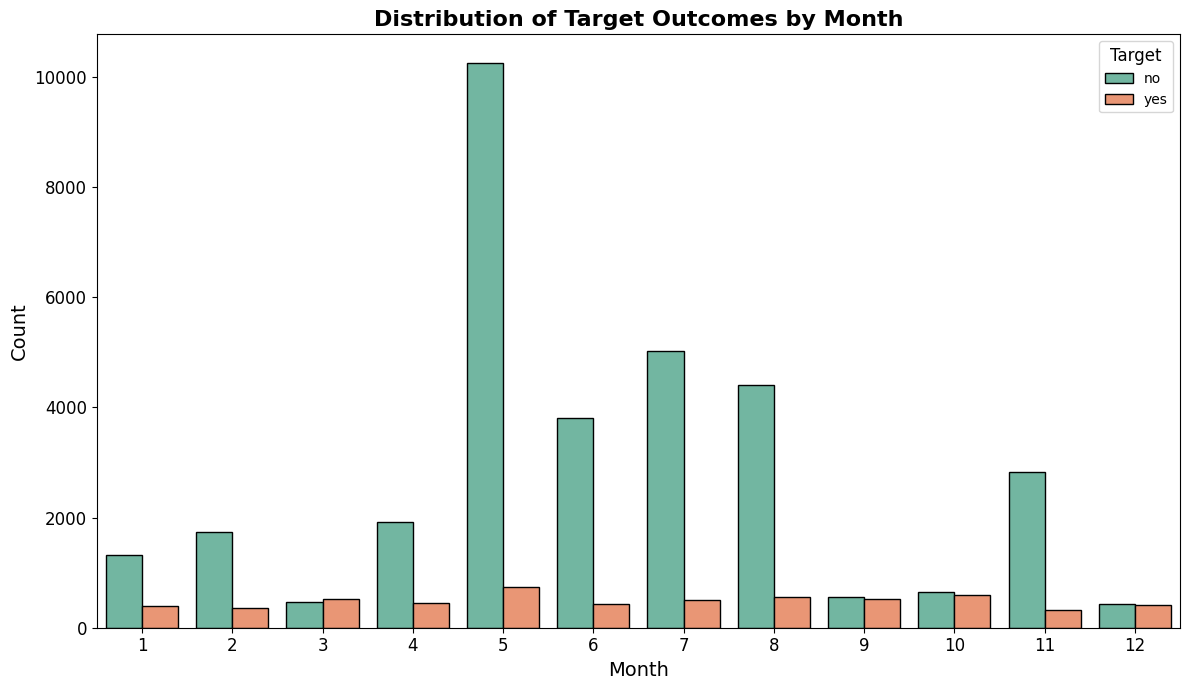

In [13]:
plt.figure(figsize=(12, 7))  
sns.countplot(
    x='month', 
    hue='target', 
    data=train, 
    palette="Set2",  
    edgecolor='black'  
)
plt.title('Distribution of Target Outcomes by Month', fontsize=16, fontweight='bold')  
plt.xlabel('Month', fontsize=14)  
plt.ylabel('Count', fontsize=14)
plt.xticks(fontsize=12)  
plt.yticks(fontsize=12) 
plt.legend(title='Target', title_fontsize=12, fontsize=10) 
plt.tight_layout() 
plt.show()


In the data, we see that the month variable is related to the target column. It's clear that "no"" values dominate over"yess" values for all months, showing an imbalance.

Specifically, May (Month 5) has a high number of "no" values, making it stand out. July (Month 7) also has a significant count of "no" values, though less than May. November (Month 11) shows a notable increase in "no" values as well.

On the other hand, "yes" values are consistently low across all months, with no major variations. Some months like 3, 6, and 8 show a slightly higher proportion of "yes" values, but the difference is small.

Overall, the data suggests seasonal patterns, with Months 5 and 7 being key for "no" values. It might be worth exploring external factors influencing these trends further.urther.urther.

#### year

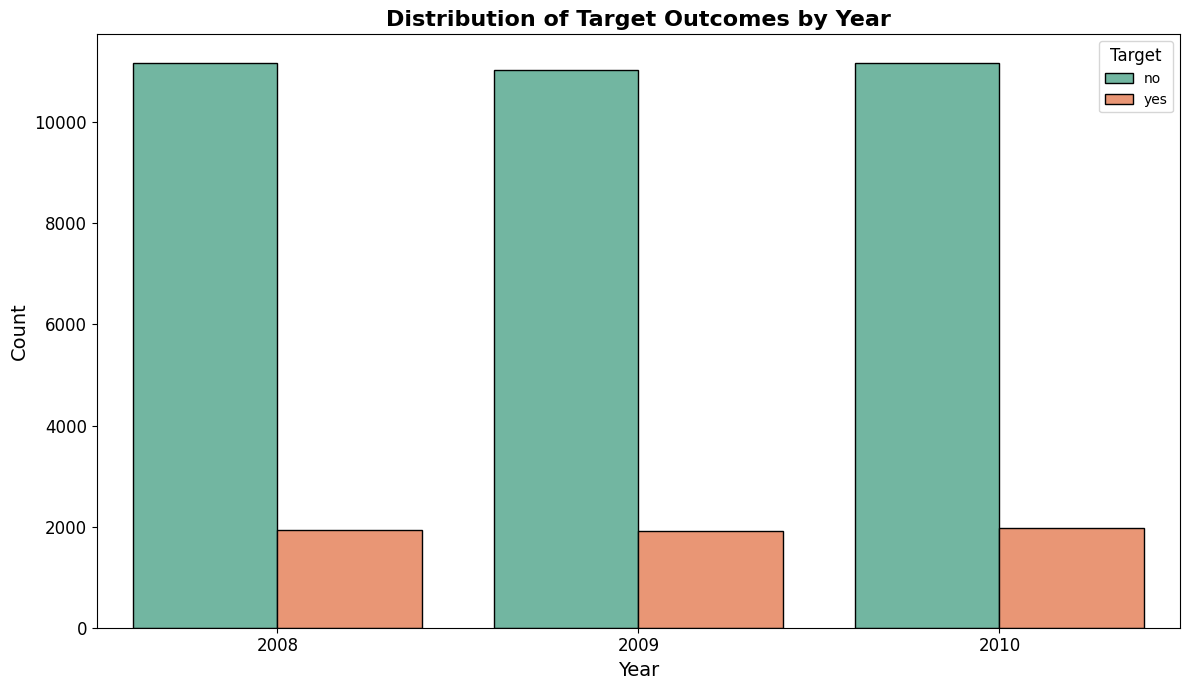

In [14]:
plt.figure(figsize=(12, 7))  
sns.countplot(
    x='year', 
    hue='target', 
    data=train, 
    palette="Set2",  
    edgecolor='black'  
)
plt.title('Distribution of Target Outcomes by Year', fontsize=16, fontweight='bold')  
plt.xlabel('Year', fontsize=14)  
plt.ylabel('Count', fontsize=14)  
plt.xticks(fontsize=12)  
plt.yticks(fontsize=12)  
plt.legend(title='Target', title_fontsize=12, fontsize=10)  
plt.tight_layout()  
plt.show()

Looking at the graph showing the relationship between year and the target column, we can see that "no" values are dominant across all years (2008, 2009, 2010), significantly outnumbering "yes" values. This imbalance remains consistent over time.

The counts of "no" and "yes" values show stability over the years, indicating no major changes in their distribution. However, there seems to be a slight decrease in "yes" values from 2008 to 2010, suggesting a potential temporal trend that may need further investigation for confirmation.

Overall, the data suggests that the year variable may not strongly predict the target outcome, as the distribution remains relatively uniform. Further analysis is necessary to explore any interactions with other features that could influence the target variale.



#### weekday

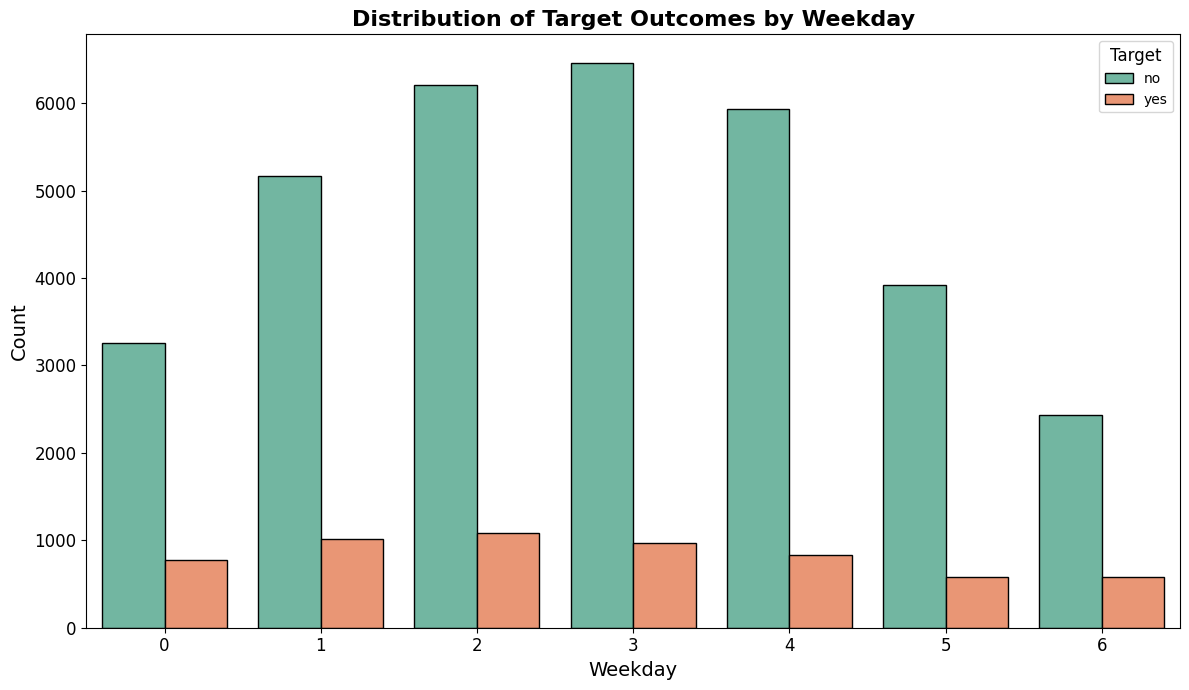

In [15]:
plt.figure(figsize=(12, 7))  
sns.countplot(
    x='weekday', 
    hue='target', 
    data=train, 
    palette="Set2",  
    edgecolor='black'  
)
plt.title('Distribution of Target Outcomes by Weekday', fontsize=16, fontweight='bold')  
plt.xlabel('Weekday', fontsize=14)  
plt.ylabel('Count', fontsize=14)  
plt.xticks(fontsize=12)  
plt.yticks(fontsize=12)  
plt.legend(title='Target', title_fontsize=12, fontsize=10)  
plt.tight_layout()  
plt.show()

Looking at the graph showing the relationship between weekdays and the target column, we notice that "no" values are consistently higher than "yes" values throughout the week.

Weekdays 2, 3, and 4 (likely Tuesday, Wednesday, and Thursday) have higher counts for both "no" and "yes" targets compared to other days. On the other hand, Fridays and Saturdays show a decrease in activity, with Saturday having the lowest level of engagement.

The number of "yes" counts remains steady across all weekdays, without any significant fluctuations. The data hints at a possible trend of more activity during weekdays (Monday to Thursday) and reduced engagement over the weekend (Friday and Saturday), possibly linked to business or operational pattes.



### Age and Target

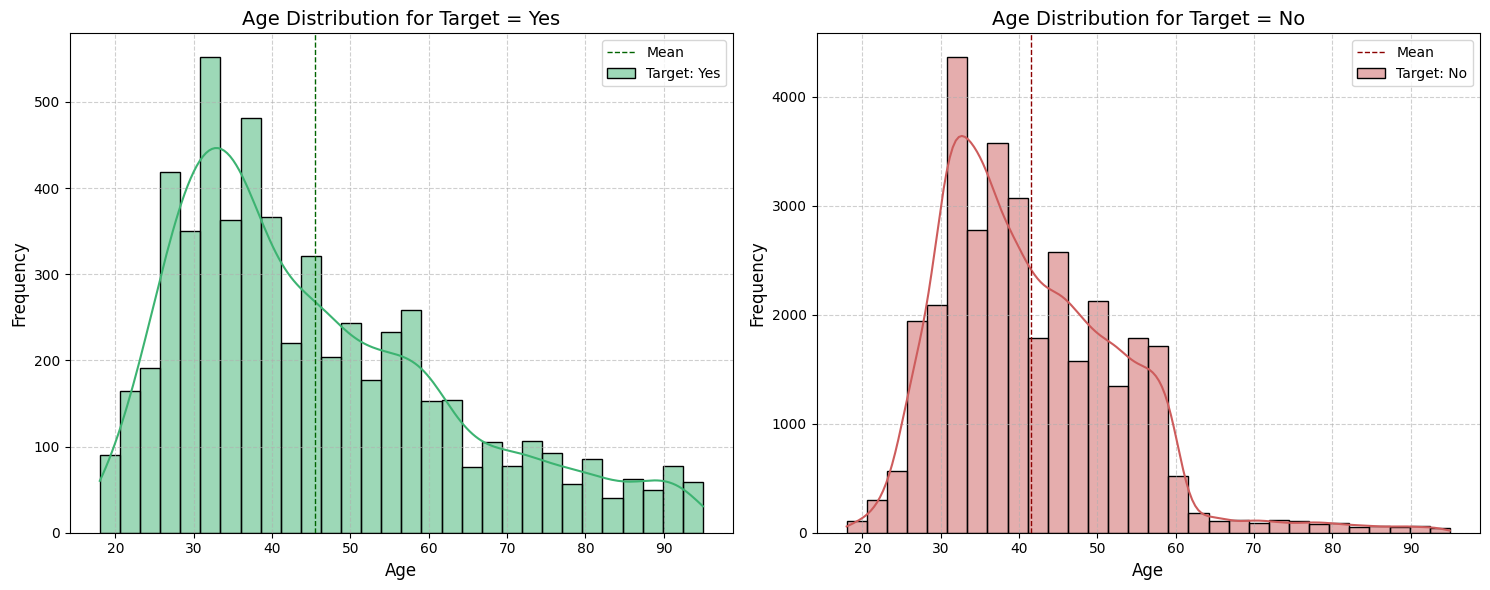

In [16]:
import warnings
warnings.filterwarnings('ignore')

df = train  

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))


sns.histplot(data=df[df['target'] == 'yes'], x='age', bins=30, kde=True, color='mediumseagreen', ax=axes[0], label='Target: Yes')
axes[0].axvline(df[df['target'] == 'yes']['age'].mean(), color='darkgreen', linestyle='--', linewidth=1, label='Mean')
axes[0].set_title('Age Distribution for Target = Yes', fontsize=14)
axes[0].set_xlabel('Age', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].legend()
axes[0].grid(visible=True, linestyle='--', alpha=0.6)


sns.histplot(data=df[df['target'] == 'no'], x='age', bins=30, kde=True, color='indianred', ax=axes[1], label='Target: No')
axes[1].axvline(df[df['target'] == 'no']['age'].mean(), color='darkred', linestyle='--', linewidth=1, label='Mean')
axes[1].set_title('Age Distribution for Target = No', fontsize=14)
axes[1].set_xlabel('Age', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].legend()
axes[1].grid(visible=True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


From the graphs provided, we can see that for the "Target = Yes" group, most individuals are in the 30-40 age range, with fewer as age increases. There is still a presence of individuals aged 70 and above, but in lower numbers.

For the "Target = No" group, the peak age range is also 30-40, but with a higher frequency. There is a broader spread of ages above 40, especially in the 40-60 range, before decreasing more sharply after 70.

Overall, the "Target = Yes" group has fewer individuals compared to "Target = No," and it tends to have a higher proportion of younger people. On the other hand, "Target = No" includes more individuals across different age ranges, especially in the older categories.

Implications suggest that age can be a significant predictor for distinguishing between the two target groups, with younger individuals more likely to be in the "Target = Yes" category. Strategies targeting the "Yes" group may benefit from focusing on younger demographics, and age could be a valuable feature in predictive modeling for the target variable.

### Job and Target

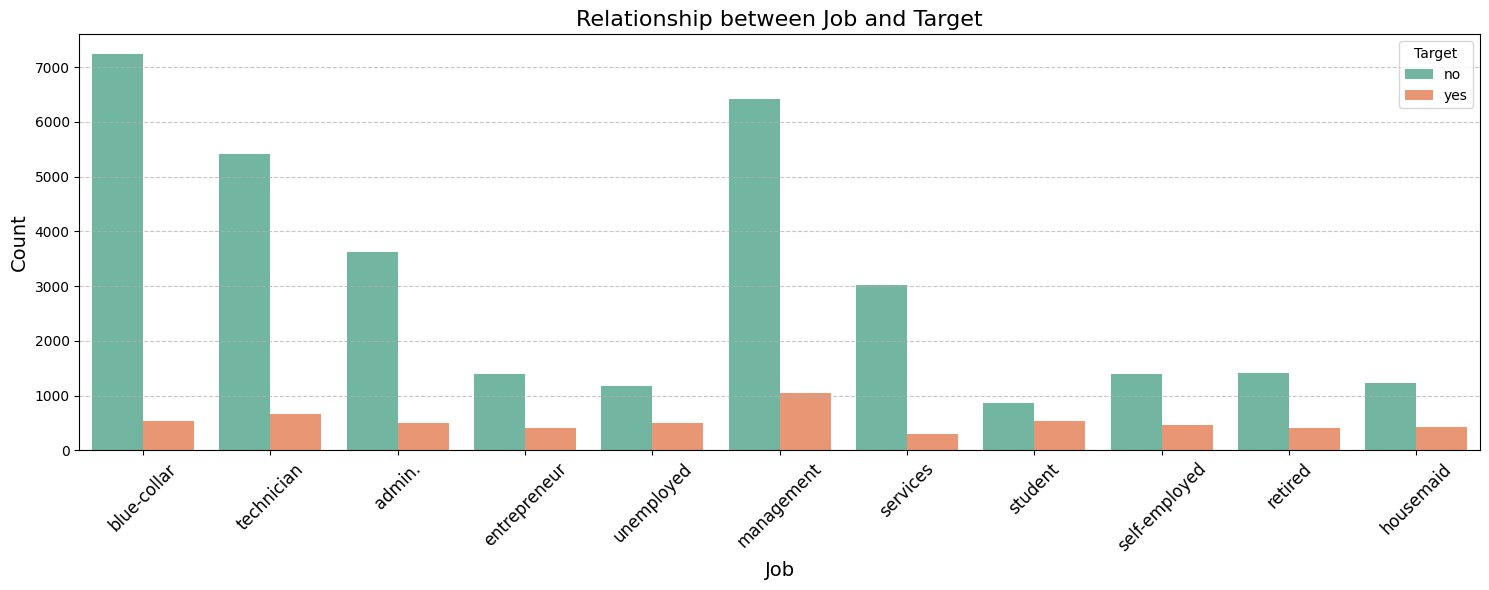

In [17]:
plt.figure(figsize=(15, 6))
sns.countplot(x='job', hue='target', data=train, palette="Set2")
plt.title('Relationship between Job and Target', fontsize=16)
plt.xlabel('Job', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45, fontsize=12)  
plt.legend(title='Target', loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


Looking at the graph showing job categories and the target variable ("yes" and "no"), we see that blue-collar and technician jobs have the highest counts, particularly in the "Target = no" category. Other notable categories include admin, management, and services.

In the "Target = Yes" group, the number of individuals is smaller across all job categories compared to "Target = no." Retired individuals and students stand out with a higher proportion of "yes" compared to categories like blue-collar or technician.

This suggests that retired individuals and students are more likely to achieve the desired target outcome. On the other hand, blue-collar jobs are more common in the "Target = no" category, indicating lower positive outcomes for this group.

Marketing strategies could target students, retired individuals, and self-employed for better outcomes. Tailored approaches may be needed for different job categories, and including job as a feature in predictive modeling could provide valuable insights due to the clear patterns seen in certain job categories.

<a id='ana'></a>
## Analysis

### Box plot for numerical columns

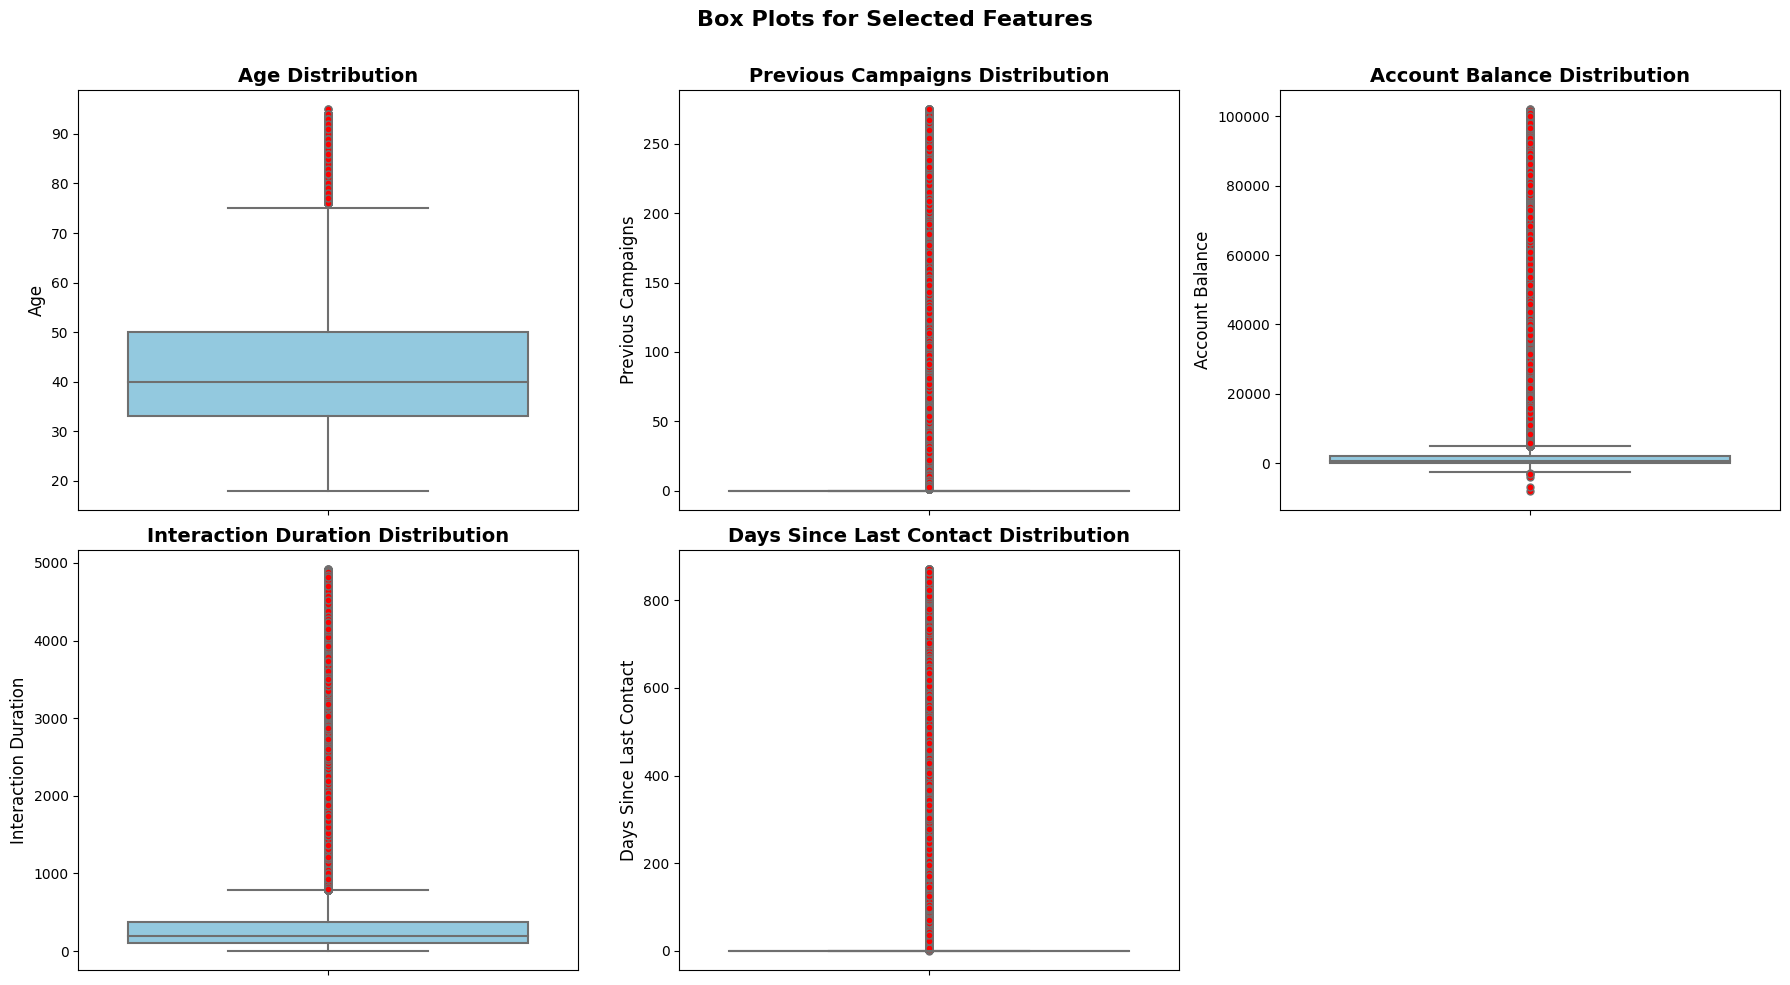

In [18]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))  


columns = ['age', 'previous', 'balance', 'duration', 'pdays']
titles = ['Age', 'Previous Campaigns', 'Account Balance', 'Interaction Duration', 'Days Since Last Contact']


for i, (col, title) in enumerate(zip(columns, titles)):
    row, col_num = divmod(i, 3)  
    sns.boxplot(
        data=df, 
        y=col, 
        ax=axes[row, col_num], 
        color='skyblue', 
        flierprops={"marker": "o", "markersize": 5, "markerfacecolor": "red"}
    )
    axes[row, col_num].set_title(f'{title} Distribution', fontsize=14, fontweight='bold')  
    axes[row, col_num].set_ylabel(title, fontsize=12)  
    axes[row, col_num].set_xlabel('')  
    axes[row, col_num].tick_params(axis='y', labelsize=10)  

axes[1, 2].axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.9)  
fig.suptitle('Box Plots for Selected Features', fontsize=16, fontweight='bold')  

plt.show()

Looking at the box plots for age, previous, balance, duration, and pdays:

Age: The age distribution looks fairly normal, with a few outliers at the older ages. Most ages fall within the range of 30 to 60.

Previous: There are many extreme outliers in the "previous" column, mainly clustered around very low values. This suggests a skewed or sparse distribution in this column.

Balance: Numerous outliers are seen at the higher end of the balance column, indicating a few individuals with very high balances. The majority of data is around zero or slightly higher.

Duration: Significant outliers are present at the higher end of the duration column, showing some very long interactions among mostly short ones. Most values are concentrated at the lower end.

Pdays: Similar to "previous," pdays also has many outliers, with some values much higher than the typical data range. The majority of values are close to zero, suggesting rare occurrences of hi values.



### Count Plot for Categorical Columns

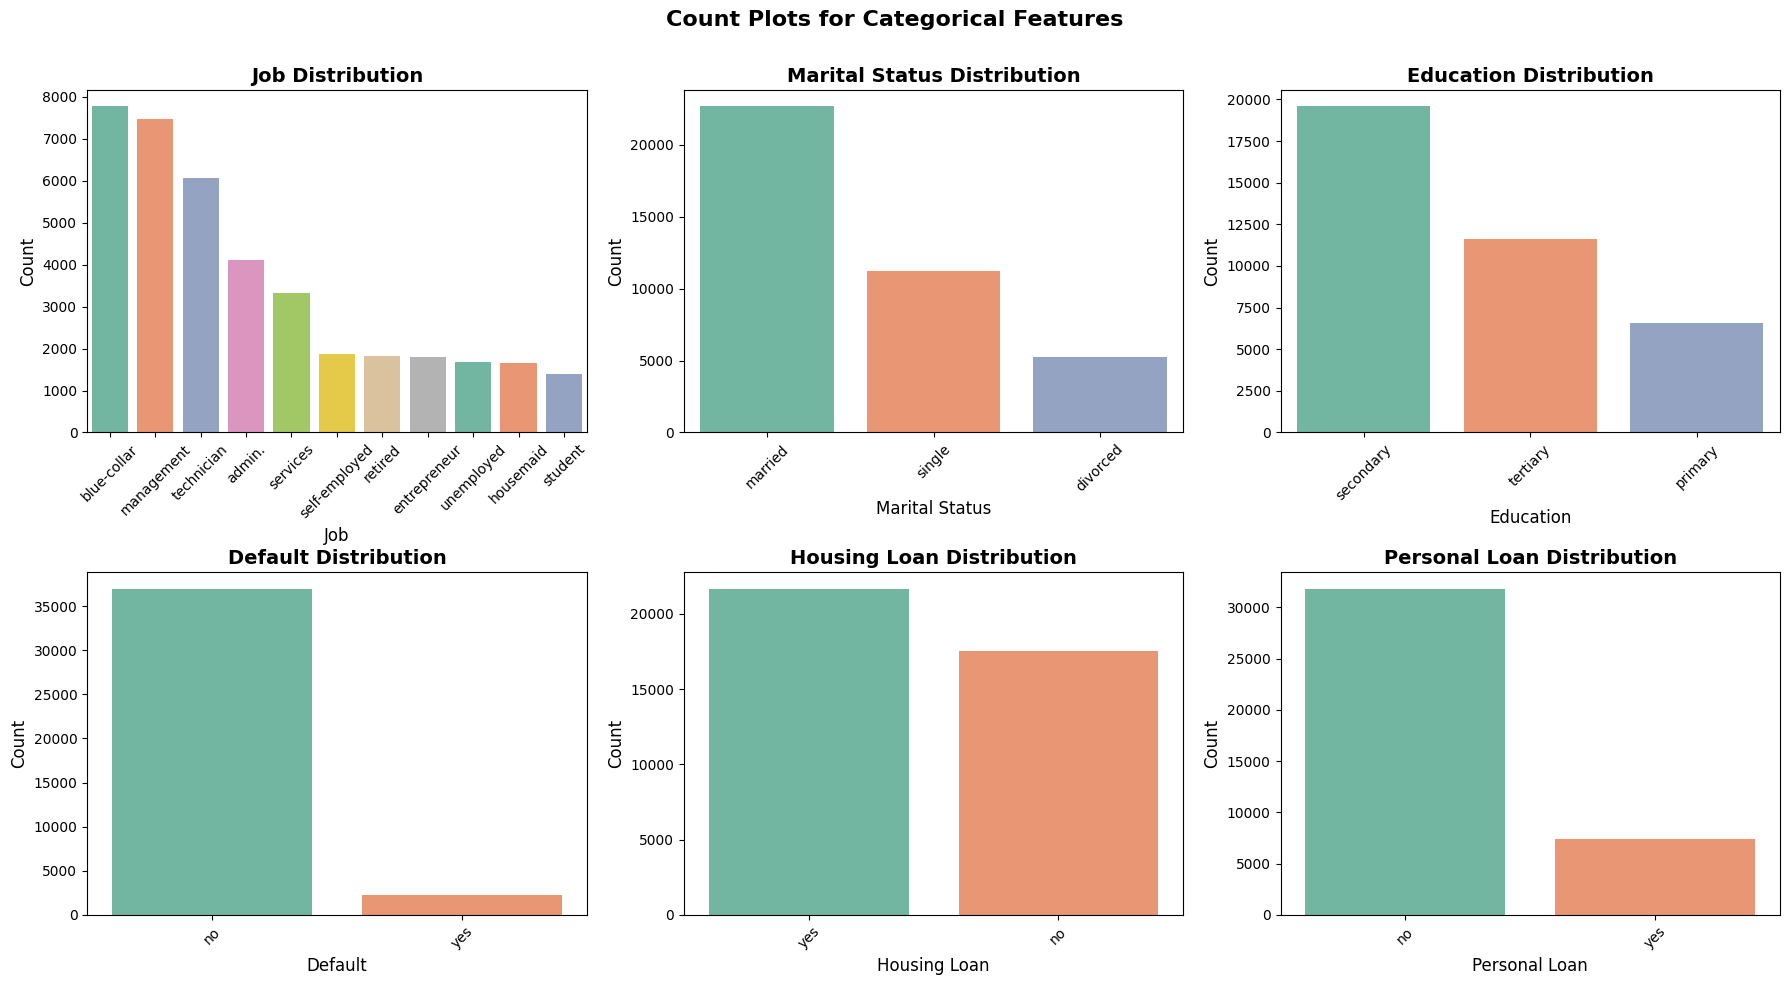

In [19]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))  


categorical_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan']
titles = ['Job', 'Marital Status', 'Education', 'Default', 'Housing Loan', 'Personal Loan']


for i, (col, title) in enumerate(zip(categorical_columns, titles)):
    row, col_num = divmod(i, 3)  
    sns.countplot(
        data=df, 
        x=col, 
        ax=axes[row, col_num], 
        palette='Set2', 
        order=df[col].value_counts().index  
    )
    axes[row, col_num].set_title(f'{title} Distribution', fontsize=14, fontweight='bold')  
    axes[row, col_num].set_xlabel(title, fontsize=12)  
    axes[row, col_num].set_ylabel('Count', fontsize=12)  
    axes[row, col_num].tick_params(axis='x', labelrotation=45, labelsize=10)  
    axes[row, col_num].tick_params(axis='y', labelsize=10)  


plt.tight_layout()
plt.subplots_adjust(top=0.9)  
fig.suptitle('Count Plots for Categorical Features', fontsize=16, fontweight='bold')  

plt.show()

### scatter plot

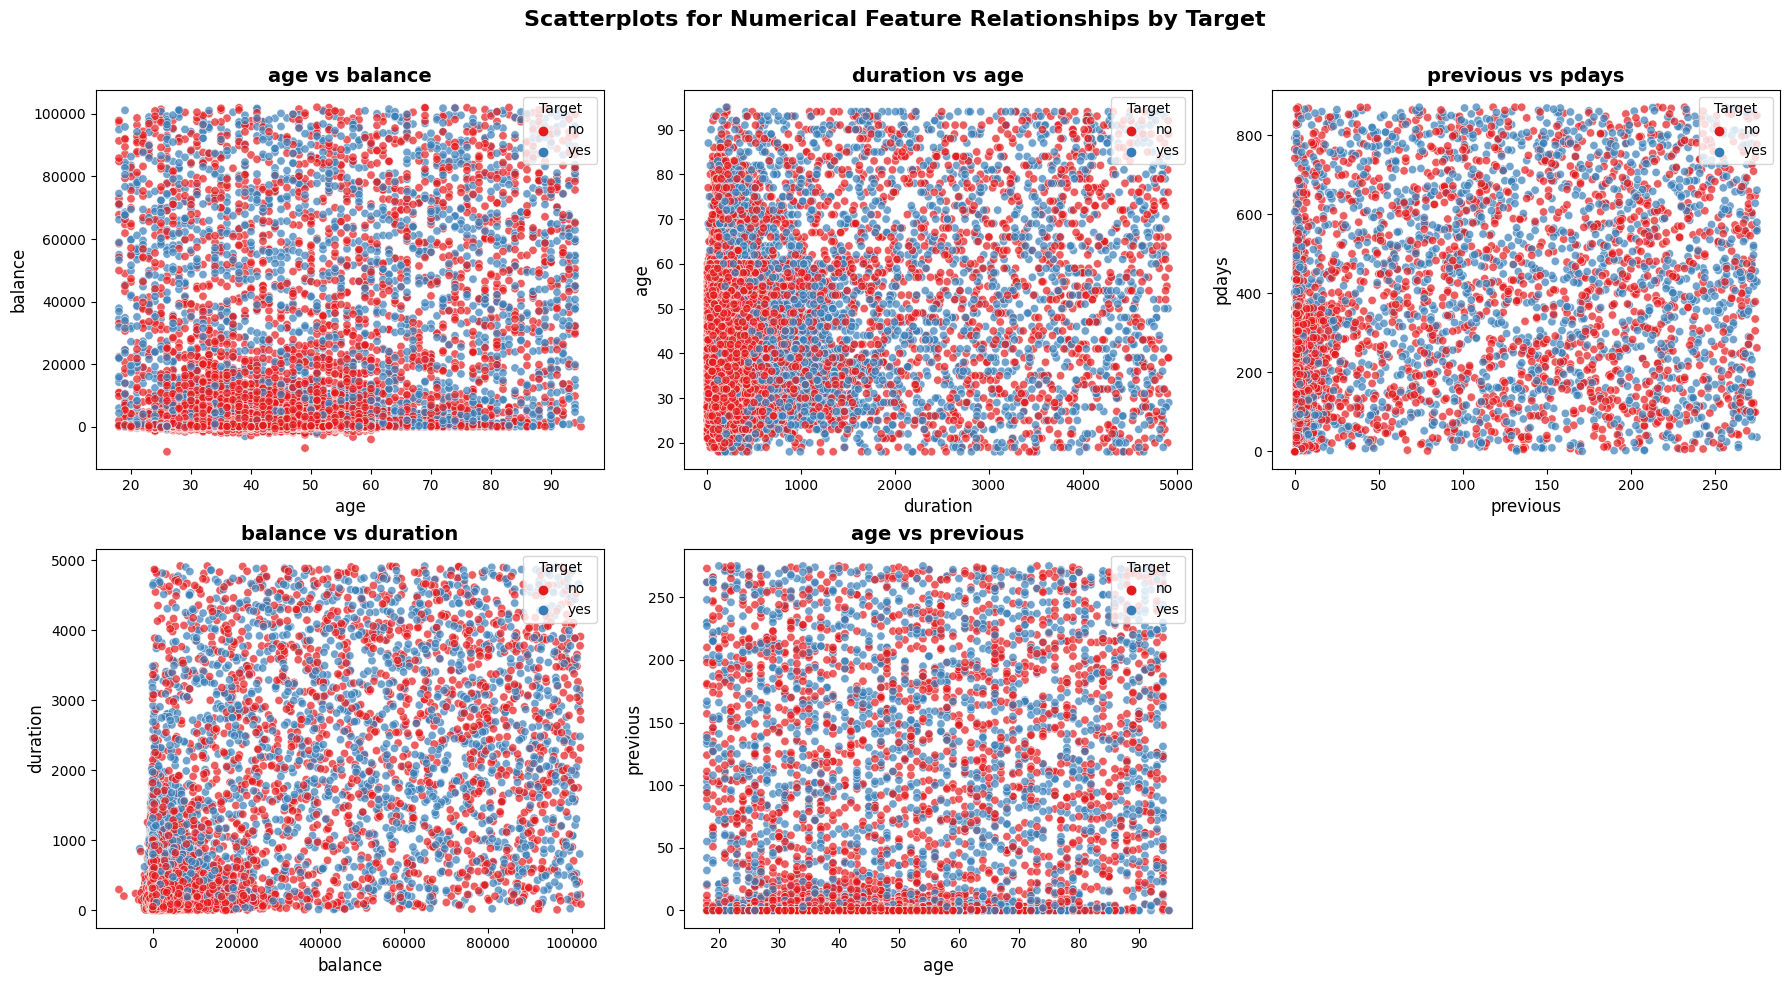

In [20]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))  


numerical_columns = ['age', 'previous', 'balance', 'duration', 'pdays']
pairs = [
    ('age', 'balance'), 
    ('duration', 'age'), 
    ('previous', 'pdays'), 
    ('balance', 'duration'), 
    ('age', 'previous')
]


for i, (x_col, y_col) in enumerate(pairs):
    row, col_num = divmod(i, 3)  
    sns.scatterplot(
        data=df, 
        x=x_col, 
        y=y_col, 
        hue='target', 
        ax=axes[row, col_num], 
        palette='Set1', 
        alpha=0.7  
    )
    axes[row, col_num].set_title(f'{x_col} vs {y_col}', fontsize=14, fontweight='bold')  
    axes[row, col_num].set_xlabel(x_col, fontsize=12)  
    axes[row, col_num].set_ylabel(y_col, fontsize=12)  
    axes[row, col_num].legend(title='Target', loc='upper right')  

axes[1, 2].axis('off')  


plt.tight_layout()
plt.subplots_adjust(top=0.9) 
fig.suptitle('Scatterplots for Numerical Feature Relationships by Target', fontsize=16, fontweight='bold')  

plt.show()

Analyzing the scatter plots revealed several insights:s beyond the scatter plots.


Age vs. Balance:

There isn't a clear correlation between a customer's age and their account balanceges.


Duration vs. Age:

Call duration doesn't show a distinct relationship with age.

Previous vs. Pdays:

The distribution of previous campaigns contacted and days since the last contact is sparse.


Balance vs. Duration:

No clear correlation between account balance and call duration is observed.


Age vs. Previous:

The distribution of previous campaigns across ages is sparse.


**Longer call durations are strongly associated with successful outcomes.**
**While individual variables like age, balance, previous, and pdays do not exhibit clear patterns alone, their interactions could offer valuable insights when considered together.**..


### Correlation

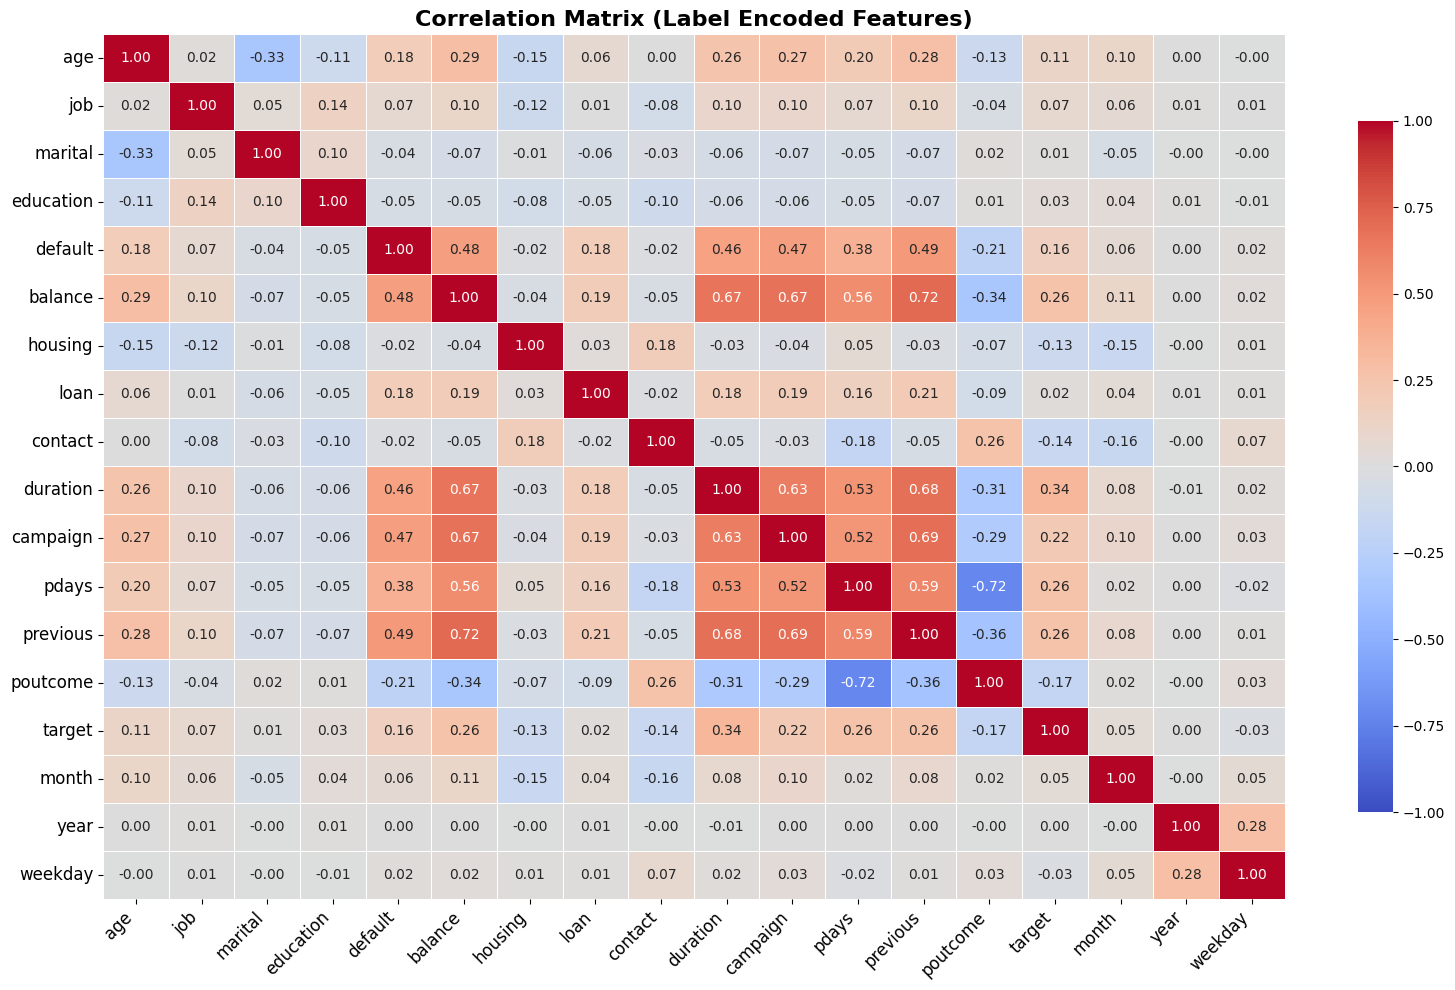

In [21]:
encoded_df = df.copy()


categorical_columns = df.select_dtypes(include=['object']).columns.tolist()


label_encoder = LabelEncoder()
for col in categorical_columns:
    encoded_df[col] = label_encoder.fit_transform(encoded_df[col])


corr_matrix = encoded_df.corr()


plt.figure(figsize=(16, 10)) 
sns.heatmap(
    corr_matrix, 
    annot=True, 
    fmt='.2f',  
    cmap='coolwarm', 
    vmin=-1, 
    vmax=1, 
    linewidths=0.5, 
    cbar_kws={"shrink": 0.8}  
)
plt.title('Correlation Matrix (Label Encoded Features)', fontsize=16, fontweight='bold') 
plt.xticks(fontsize=12, rotation=45, ha='right')  
plt.yticks(fontsize=12) 
plt.tight_layout()  
plt.show()

Upon analyzing the correlation matrix, important connections have surfaced. Notably, the duration of interactions plays a significant role in determining the target outcome. There is a strong link between pdays and previous, suggesting shared underlying information. Moreover, individuals with higher balances are more likely to meet the target. Conversely, longer intervals since the last contact (pdays) may result in poorer outcomes. Age distributions vary among different marital statuses. Features like loan, housing, contact, and education show minimal correlation with the target, indicating a lesser impact on the outcome. These insights help identify critical variables for modeling and those that have a smaller influence.ips with the target.

<a id='tar'></a>
### Target Distribution

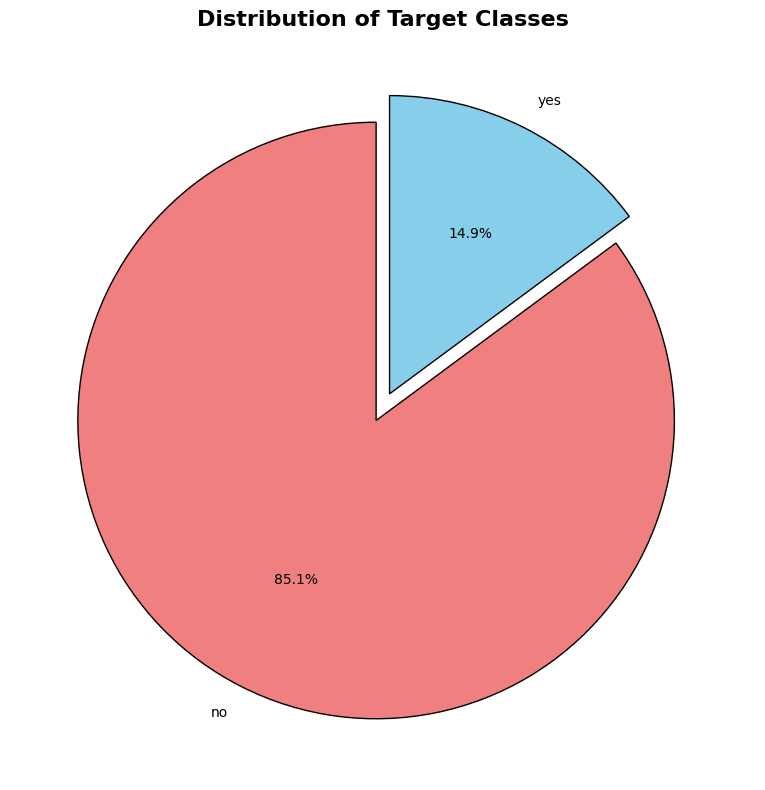

In [22]:
target_counts = df['target'].value_counts()


plt.figure(figsize=(8, 8))  
plt.pie(
    target_counts, 
    labels=target_counts.index, 
    autopct='%1.1f%%',  
    startangle=90,  
    colors=['lightcoral', 'skyblue'],  
    explode=[0.05] * len(target_counts),  
    wedgeprops={'edgecolor': 'black', 'linewidth': 1}  
)


plt.title('Distribution of Target Classes', fontsize=16, fontweight='bold')


plt.tight_layout()  
plt.show()

The graph in your image represents the distribution of target classes, specifically showing the proportion of "yes" (14.9%) and "no" (85.1%) categories in the target column.

Class Imbalance- Such an imbalance could affect the performance of machine learning models, particularly those sensitive to class distribution (e.g., logistic regression, decision trees).

<a id='imp'></a>
## Imputation

Handling null values

#### **Imputation with mode**

In [23]:
X, y = train.drop(columns=['target']), train['target']
cols = X.columns


imputer = SimpleImputer(strategy='most_frequent')


X = pd.DataFrame(imputer.fit_transform(X), columns=cols)


test = pd.DataFrame(imputer.transform(test), columns=cols)

In [24]:
X.isna().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
month        0
year         0
weekday      0
dtype: int64

Check for null values

#### Label Encoding

In [25]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Train-Test Split


In [26]:
from sklearn.model_selection import train_test_split
x_train,x_val,y_train,y_val = train_test_split(X,y,test_size=0.2,stratify=y)

<a id='pre'></a>
## Data Preprocessing and Feature Engineering

In [27]:
categorical_col = ['marital','housing','loan','default','weekday','contact','education','job','poutcome','previous','age']
numerical_col = ['age','previous','pdays','duration','balance']

Transformer = ColumnTransformer([('scale',StandardScaler(),numerical_col),
                                ('encode',OneHotEncoder(),categorical_col)],remainder='passthrough')

x_train_transformed = Transformer.fit_transform(x_train)
x_test_transformed = Transformer.transform(x_val)
x_test_transformed_final = Transformer.transform(test)

#### **Feature Selection**

#### RFE

In [28]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(x_train_transformed, y_train)

selector_model = SelectFromModel(model, prefit=True, threshold="mean")
x_train_selected_model = selector_model.transform(x_train_transformed)
x_test_selected_model = selector_model.transform(x_test_transformed)
x_test_transformed_final_model = selector_model.transform(x_test_transformed_final)

selected_indices_model = selector_model.get_support(indices=True)

#### SelectKBest

In [29]:
selector_f_classif = SelectKBest(score_func=f_classif, k=150)
x_train_selected_f_classif = selector_f_classif.fit_transform(x_train_transformed, y_train)
x_test_selected_f_classif = selector_f_classif.transform(x_test_transformed)
x_test_transformed_final_f_classif = selector_f_classif.transform(x_test_transformed_final)
selected_indices_f_classif = selector_f_classif.get_support(indices=True)


feature_names = list(Transformer.get_feature_names_out())
selected_features_f_classif = [feature_names[i] for i in selected_indices_f_classif]

print("Selected Features using f_classif:", selected_features_f_classif)

Selected Features using f_classif: ['scale__age', 'scale__previous', 'scale__pdays', 'scale__duration', 'scale__balance', 'encode__marital_divorced', 'encode__marital_married', 'encode__marital_single', 'encode__housing_no', 'encode__housing_yes', 'encode__default_no', 'encode__default_yes', 'encode__weekday_0', 'encode__weekday_3', 'encode__weekday_4', 'encode__weekday_6', 'encode__contact_cellular', 'encode__contact_telephone', 'encode__education_secondary', 'encode__education_tertiary', 'encode__job_admin.', 'encode__job_blue-collar', 'encode__job_entrepreneur', 'encode__job_housemaid', 'encode__job_retired', 'encode__job_self-employed', 'encode__job_services', 'encode__job_student', 'encode__job_technician', 'encode__job_unemployed', 'encode__poutcome_failure', 'encode__poutcome_other', 'encode__poutcome_success', 'encode__previous_0', 'encode__previous_1', 'encode__previous_2', 'encode__previous_3', 'encode__previous_4', 'encode__previous_5', 'encode__previous_6', 'encode__previou

<a id='mod'></a>
## Model Training

#### **Logistic Regression**

In [30]:
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(x_train_transformed, y_train)

y_pred = log_reg.predict(x_test_transformed)

print(classification_report(y_val, y_pred, target_names=['No', 'Yes']))

              precision    recall  f1-score   support

          No       0.88      0.97      0.92      6677
         Yes       0.58      0.25      0.35      1166

    accuracy                           0.86      7843
   macro avg       0.73      0.61      0.64      7843
weighted avg       0.84      0.86      0.84      7843



#### Selected with model features

In [31]:
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(x_train_selected_model, y_train)

y_pred = log_reg.predict(x_test_selected_model)

print(classification_report(y_val, y_pred, target_names=['No', 'Yes']))

              precision    recall  f1-score   support

          No       0.88      0.97      0.92      6677
         Yes       0.58      0.25      0.35      1166

    accuracy                           0.86      7843
   macro avg       0.73      0.61      0.63      7843
weighted avg       0.84      0.86      0.84      7843



#### Selected with f_classif features

In [32]:
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(x_train_selected_f_classif, y_train)

y_pred = log_reg.predict(x_test_selected_f_classif)

print(classification_report(y_val, y_pred, target_names=['No', 'Yes']))

              precision    recall  f1-score   support

          No       0.88      0.97      0.92      6677
         Yes       0.57      0.23      0.33      1166

    accuracy                           0.86      7843
   macro avg       0.72      0.60      0.62      7843
weighted avg       0.83      0.86      0.83      7843



#### **XGBoost**

In [33]:
model = XGBClassifier()
model.fit(x_train_transformed, y_train)

y_pred = model.predict(x_test_transformed)

print(classification_report(y_val, y_pred, target_names=['No', 'Yes']))

              precision    recall  f1-score   support

          No       0.91      0.95      0.93      6677
         Yes       0.60      0.46      0.52      1166

    accuracy                           0.87      7843
   macro avg       0.76      0.71      0.73      7843
weighted avg       0.86      0.87      0.87      7843



## Cleared Cutoff with XGB and probability twiking

In [34]:
probability = model.predict_proba(x_test_transformed)
p_proba=probability[:,1]
preds=(p_proba >= 0.24).astype(int)
print(classification_report(y_val,preds))

              precision    recall  f1-score   support

           0       0.96      0.87      0.91      6677
           1       0.51      0.79      0.62      1166

    accuracy                           0.85      7843
   macro avg       0.73      0.83      0.76      7843
weighted avg       0.89      0.85      0.87      7843



**LGBMClassifier**

In [35]:
from lightgbm import LGBMClassifier
model = LGBMClassifier()
model.fit(x_train_transformed, y_train)

y_pred = model.predict(x_test_transformed)

print(classification_report(y_val, y_pred, target_names=['No', 'Yes']))

[LightGBM] [Info] Number of positive: 4661, number of negative: 26707
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007791 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1427
[LightGBM] [Info] Number of data points in the train set: 31368, number of used features: 136
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.148591 -> initscore=-1.745696
[LightGBM] [Info] Start training from score -1.745696
              precision    recall  f1-score   support

          No       0.91      0.94      0.93      6677
         Yes       0.59      0.47      0.52      1166

    accuracy                           0.87      7843
   macro avg       0.75      0.71      0.72      7843
weighted avg       0.86      0.87      0.87      7843



In [36]:
probability = model.predict_proba(x_test_transformed)
p_proba=probability[:,1]
preds=(p_proba >= 0.24).astype(int)
print(classification_report(y_val,preds))

              precision    recall  f1-score   support

           0       0.96      0.86      0.91      6677
           1       0.50      0.82      0.62      1166

    accuracy                           0.85      7843
   macro avg       0.73      0.84      0.76      7843
weighted avg       0.89      0.85      0.86      7843



### Decision Tree Classifier

In [37]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()
model.fit(x_train_transformed, y_train)

y_pred = model.predict(x_test_transformed)

print(classification_report(y_val, y_pred, target_names=['No', 'Yes']))

              precision    recall  f1-score   support

          No       0.90      0.90      0.90      6677
         Yes       0.44      0.43      0.43      1166

    accuracy                           0.83      7843
   macro avg       0.67      0.67      0.67      7843
weighted avg       0.83      0.83      0.83      7843



<a id='hyp'></a>
## HyperParameter Tuning

### **LOG REG HPT**

In [38]:
# warnings.filterwarnings('ignore')

# from sklearn.model_selection import GridSearchCV


# param_grid = {
#     'C': [0.01, 0.1, 1, 10, 100],  
#     'penalty': ['l1', 'l2', 'elasticnet', 'none'],  
#     'solver': ['liblinear']  
# }

# model = LogisticRegression(max_iter=1000)

# grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1_macro',verbose=3)

# grid_search.fit(x_train_transformed, y_train)

# best_params = grid_search.best_params_
# print("Best parameters found: ", best_params)

# best_model = grid_search.best_estimator_
# y_pred = best_model.predict(x_test_transformed)

# print(classification_report(y_val, y_pred, target_names=['No', 'Yes']))

### **XGBoost HPT**

In [39]:
# from sklearn.model_selection import GridSearchCV

# param_grid = {
#     'learning_rate': [0.01, 0.05, 0.1],
#     'max_depth': [-1, 5, 10, 20],
#     'n_estimators': [100, 200, 300]
# }

# model = XGBClassifier()

# grid_search = GridSearchCV(model, param_grid, cv=3, scoring='f1_macro',verbose=3)

# grid_search.fit(x_train_transformed, y_train)

# best_params = grid_search.best_params_
# print("Best parameters found: ", best_params)

# best_model = grid_search.best_estimator_
# y_pred = best_model.predict(x_test_transformed)

# print(classification_report(y_val, y_pred, target_names=['No', 'Yes']))

### **LGBM HPT**

In [40]:
# from sklearn.model_selection import GridSearchCV

# param_grid = {
#     'learning_rate': [0.01, 0.1, 0.2],
#     'n_estimators': [100, 200, 300],
#     'max_depth': [-1, 5, 10],
# }

# model = LGBMClassifier()

# grid_search = GridSearchCV(model, param_grid, cv=3, scoring='f1_macro',verbose=3)

# grid_search.fit(x_train_transformed, y_train)

# best_params = grid_search.best_params_
# print("Best parameters found: ", best_params)

# best_model = grid_search.best_estimator_
# y_pred = best_model.predict(x_test_transformed)

# print(classification_report(y_val, y_pred, target_names=['No', 'Yes']))

<a id='eval'></a>
## Model Evaluation

### **XGB**

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.87      0.91      6677
           1       0.51      0.79      0.62      1166

    accuracy                           0.85      7843
   macro avg       0.73      0.83      0.76      7843
weighted avg       0.89      0.85      0.87      7843



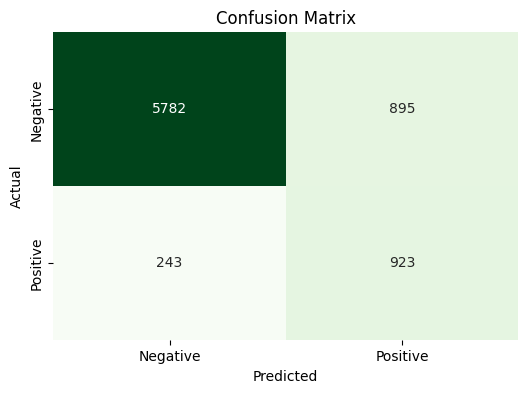

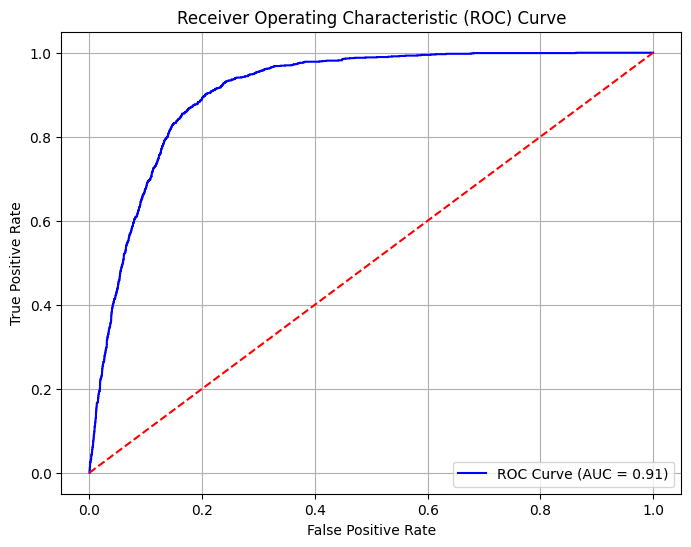

In [41]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from xgboost import XGBClassifier


model = XGBClassifier()
model.fit(x_train_transformed, y_train)


y_pred_proba = model.predict_proba(x_test_transformed)[:, 1]  
threshold = 0.24  
y_pred = (y_pred_proba >= threshold).astype(int)  


print("Classification Report:")
print(classification_report(y_val, y_pred))


cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False, 
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
roc_auc = roc_auc_score(y_val, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

### **Logistic Regression**

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.92      0.91      6677
           1       0.50      0.44      0.47      1166

    accuracy                           0.85      7843
   macro avg       0.70      0.68      0.69      7843
weighted avg       0.84      0.85      0.85      7843



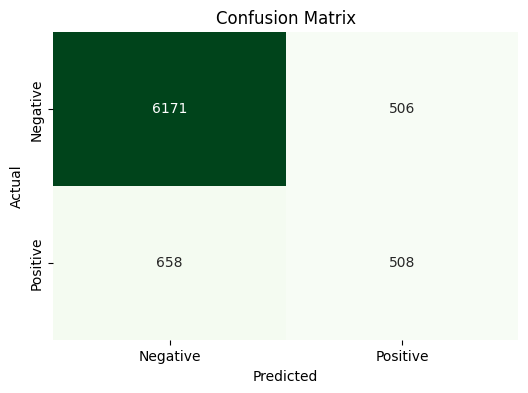

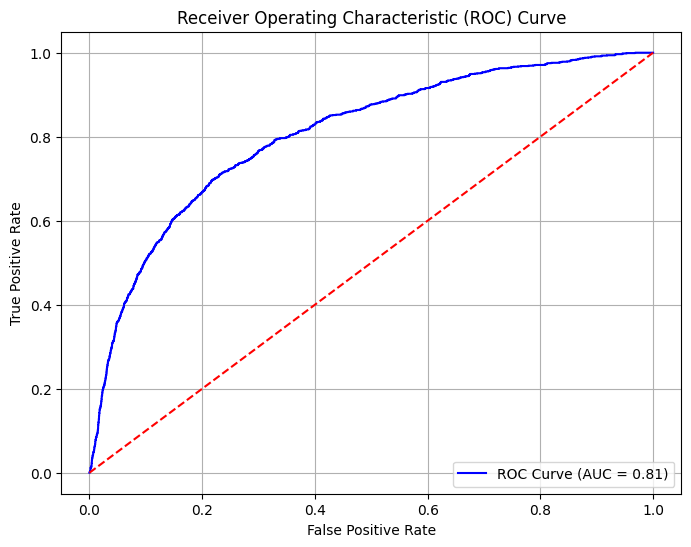

In [42]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression


model = LogisticRegression()
model.fit(x_train_transformed, y_train)


y_pred_proba = model.predict_proba(x_test_transformed)[:, 1] 
threshold = 0.24  
y_pred = (y_pred_proba >= threshold).astype(int)  


print("Classification Report:")
print(classification_report(y_val, y_pred))


cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False, 
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve and AUC Score
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
roc_auc = roc_auc_score(y_val, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

### **XGB Tunned**

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.87      0.91      6677
           1       0.51      0.80      0.62      1166

    accuracy                           0.86      7843
   macro avg       0.73      0.83      0.77      7843
weighted avg       0.89      0.86      0.87      7843



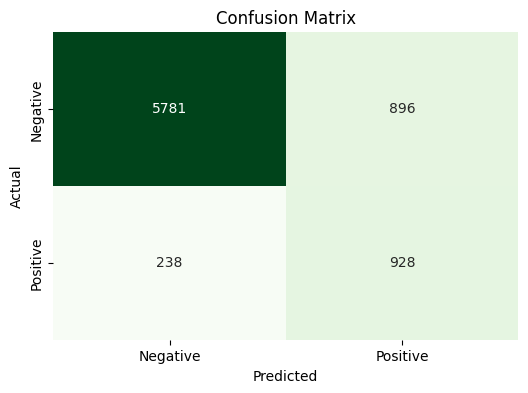

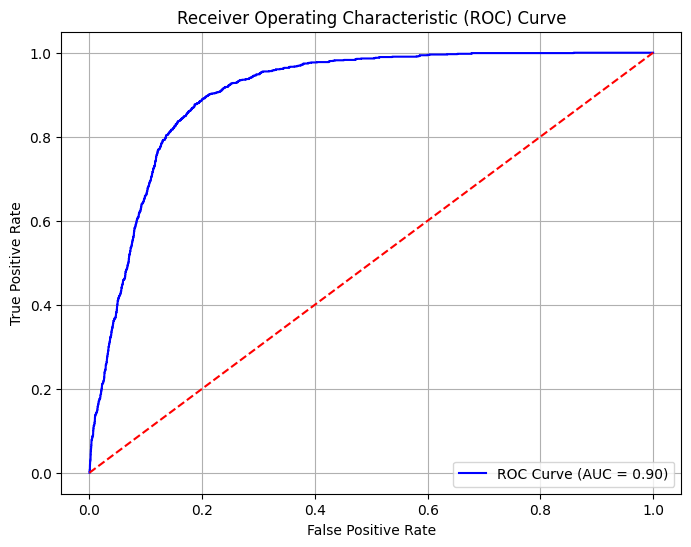

In [43]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from xgboost import XGBClassifier


model = XGBClassifier(learning_rate=0.1, max_depth=10, n_estimators=100, random_state=42)
model.fit(x_train_transformed, y_train)


y_pred_proba = model.predict_proba(x_test_transformed)[:, 1] 
threshold = 0.24  
y_pred = (y_pred_proba >= threshold).astype(int) 


print("Classification Report:")
print(classification_report(y_val, y_pred))


cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False, 
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
roc_auc = roc_auc_score(y_val, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

### **LGBM Tunned**

[LightGBM] [Info] Number of positive: 4661, number of negative: 26707
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008309 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1427
[LightGBM] [Info] Number of data points in the train set: 31368, number of used features: 136
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.148591 -> initscore=-1.745696
[LightGBM] [Info] Start training from score -1.745696
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.86      0.91      6677
           1       0.50      0.80      0.61      1166

    accuracy                           0.85      7843
   macro avg       0.73      0.83      0.76      7843
weighted avg       0.89      0.85      0.86      7843



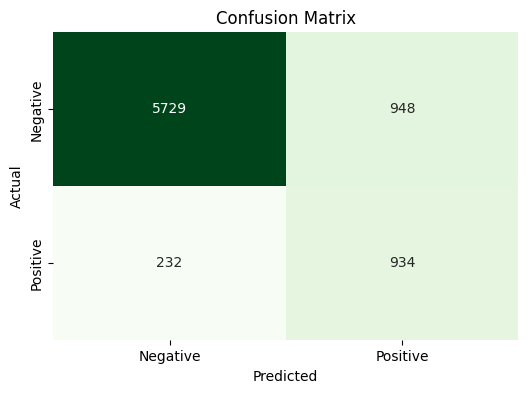

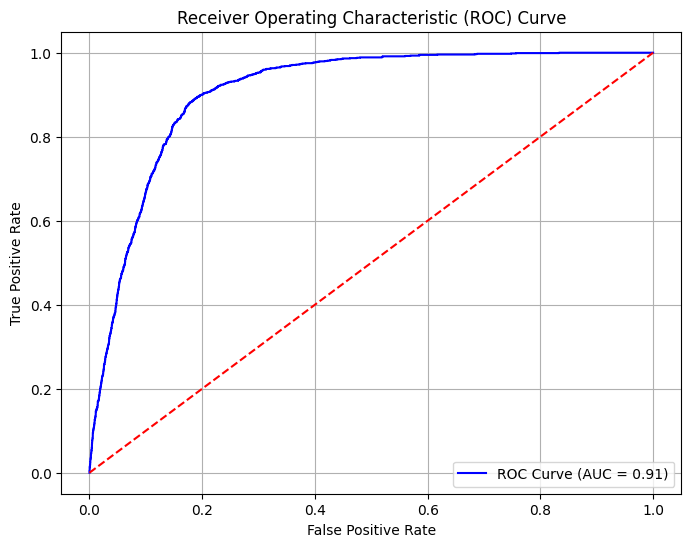

In [44]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from lightgbm import LGBMClassifier


model = LGBMClassifier(learning_rate=0.2, max_depth=-1, n_estimators=100, random_state=42)
model.fit(x_train_transformed, y_train)


y_pred_proba = model.predict_proba(x_test_transformed)[:, 1]  
threshold = 0.24  
y_pred = (y_pred_proba >= threshold).astype(int)  


print("Classification Report:")
print(classification_report(y_val, y_pred))


cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False, 
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
roc_auc = roc_auc_score(y_val, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--') 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

## Model Comparision

[LightGBM] [Info] Number of positive: 4661, number of negative: 26707
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008251 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1427
[LightGBM] [Info] Number of data points in the train set: 31368, number of used features: 136
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.148591 -> initscore=-1.745696
[LightGBM] [Info] Start training from score -1.745696


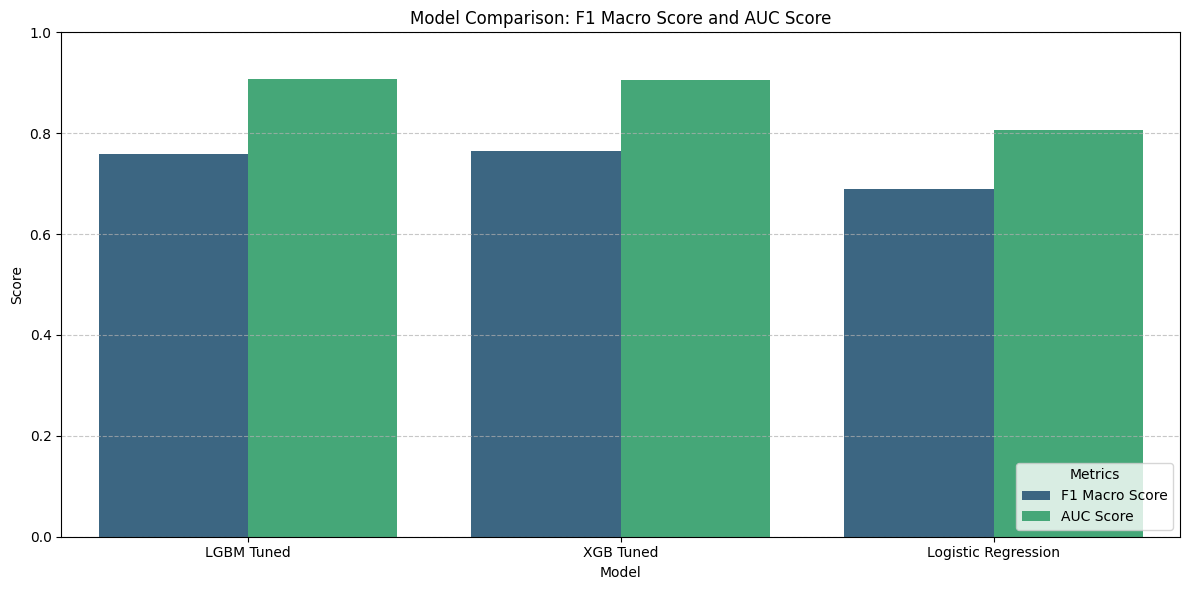

In [45]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, f1_score

models = {
    'LGBM Tuned': LGBMClassifier(learning_rate=0.2, max_depth=-1, n_estimators=100, random_state=42),
    'XGB Tuned': XGBClassifier(learning_rate=0.1, max_depth=10, n_estimators=100, random_state=42),
    'Logistic Regression': LogisticRegression()
}


metrics = {'Model': [], 'F1 Macro Score': [], 'AUC Score': []}


for model_name, model in models.items():
    
    model.fit(x_train_transformed, y_train)

   
    y_pred_proba = model.predict_proba(x_test_transformed)[:, 1] 
    threshold = 0.24
    y_pred_thresholded = (y_pred_proba >= threshold).astype(int)  

   
    f1_macro = f1_score(y_val, y_pred_thresholded, average='macro')
    auc = roc_auc_score(y_val, y_pred_proba)

    
    metrics['Model'].append(model_name)
    metrics['F1 Macro Score'].append(f1_macro)
    metrics['AUC Score'].append(auc)


metrics_df = pd.DataFrame(metrics)


metrics_df_melted = metrics_df.melt(id_vars='Model', var_name='Metric', value_name='Score')

plt.figure(figsize=(12, 6))
sns.barplot(data=metrics_df_melted, x='Model', y='Score', hue='Metric', palette='viridis')
plt.title('Model Comparison: F1 Macro Score and AUC Score')
plt.ylabel('Score')
plt.xlabel('Model')
plt.ylim(0, 1)  
plt.legend(title='Metrics', loc='lower right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

<a id='sub'></a>
# Final Submission

---

In [46]:
x_test_transformed_final = Transformer.transform(test)

In [47]:
x_train_final = Transformer.fit_transform(X)
x_test_final = Transformer.transform(test)

In [48]:
final_model = LGBMClassifier(learning_rate=0.2, max_depth=-1, n_estimators=100)
final_model.fit(x_train_final, y)

probs = final_model.predict_proba(x_test_final)[:, 1]

preds = (probs >= 0.24).astype(int)

[LightGBM] [Info] Number of positive: 5827, number of negative: 33384
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011990 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1440
[LightGBM] [Info] Number of data points in the train set: 39211, number of used features: 144
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.148606 -> initscore=-1.745574
[LightGBM] [Info] Start training from score -1.745574


In [49]:
submission = pd.DataFrame({"id": range(0,x_test_final.shape[0]), 
                           "target": label_encoder.inverse_transform(preds)})

submission.to_csv('submission.csv', index = False)